Estimating the value of a used car is one of the main everyday challenges in the automotive business. We believe that the sales price of a car is not only based on the value of the product itself, but is also heavily influenced by things like market trends, current availability, and politics.
With this challenge, we hope to raise some interest in this exciting topic and also gain some insight into what the main factors are that drive the value of a used car.

The data provided consists of almost 5000 real BMW cars that were sold via a b2b auction in 2018. The price shown in the table is the highest bid that was reached during the auction.

We have already done some data cleanup and filtered out cars with engine damage etc. However there may still be minor damages like scratches, but we do not have more information about that.

We have also extracted 8 criteria based on the equipment of cars that we think might have a good impact on the value of a used car. These criteria have been labeled feature1 to feature8 and are shown in the data below.

## 0. Importing Libraries

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
import bisect

import warnings
warnings.filterwarnings('ignore')

##  1. Reading data

In [77]:
df = pd.read_csv("bmw_pricing_challenge.csv")

In [78]:
df.head()

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,BMW,118,140411,100,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,2018-01-01
1,BMW,M4,13929,317,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2018-02-01
2,BMW,320,183297,120,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2018-02-01
3,BMW,420,128035,135,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2018-02-01
4,BMW,425,97097,160,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,2018-04-01


In [79]:
df.shape

(4843, 18)

In [80]:
df.describe()

,mileage,engine_power,price
count,4.843000e+03,4843.00000,4843.000000
mean,1.409628e+05,128.98823,15828.081767
std,6.019674e+04,38.99336,9220.285684
min,-6.400000e+01,0.00000,100.000000
25%,1.029135e+05,100.00000,10800.000000
50%,1.410800e+05,120.00000,14200.000000
75%,1.751955e+05,135.00000,18600.000000
max,1.000376e+06,423.00000,178500.000000


## 2. Exploratory Data Analysis

### 2.1. Missing Values

Check if the dataset contains any missing values.

In [81]:
df.isna().sum(axis=0)

maker_key            0
model_key            0
mileage              0
engine_power         0
registration_date    0
fuel                 0
paint_color          0
car_type             0
feature_1            0
feature_2            0
feature_3            0
feature_4            0
feature_5            0
feature_6            0
feature_7            0
feature_8            0
price                0
sold_at              0
dtype: int64

### 2.2. Distribution of the target variable

Plot the probabilistic distribution of the target variable.

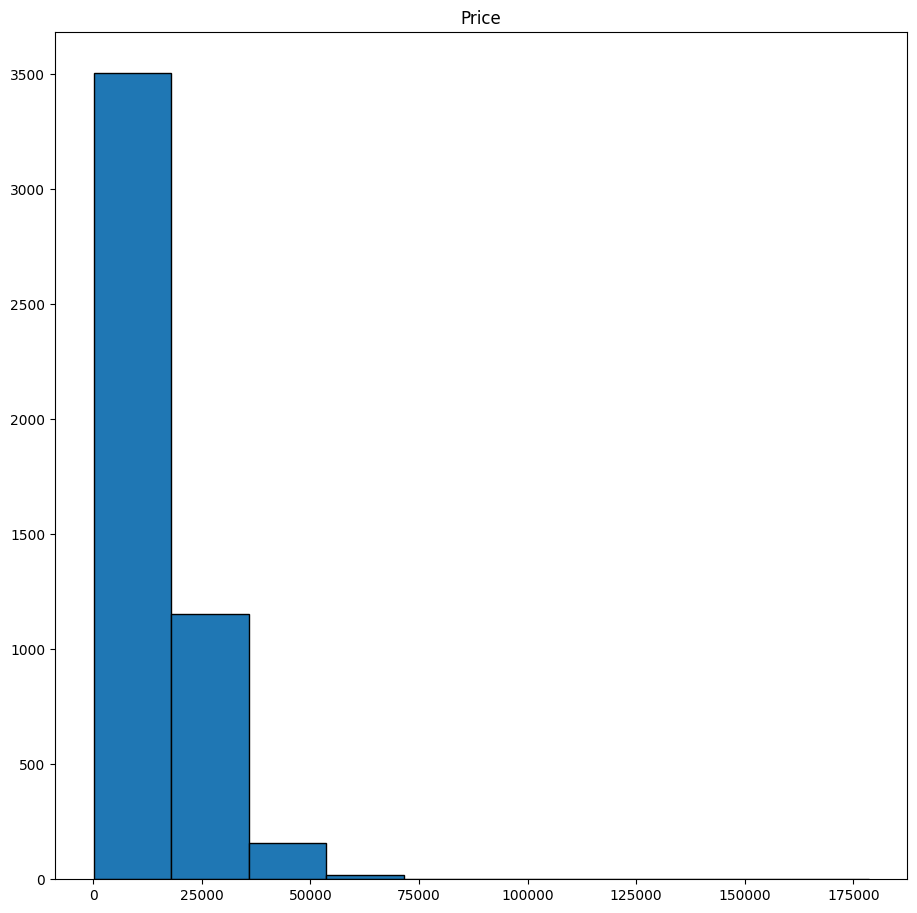

In [82]:
#plot a histogram of the price
plt.figure(figsize=(11, 11))
plt.hist(df['price'], edgecolor='black')
plt.title('Price')
plt.show()

### 2.3. Distribution of numerical variables

Plot the probabilistic distribution of the numerical features.

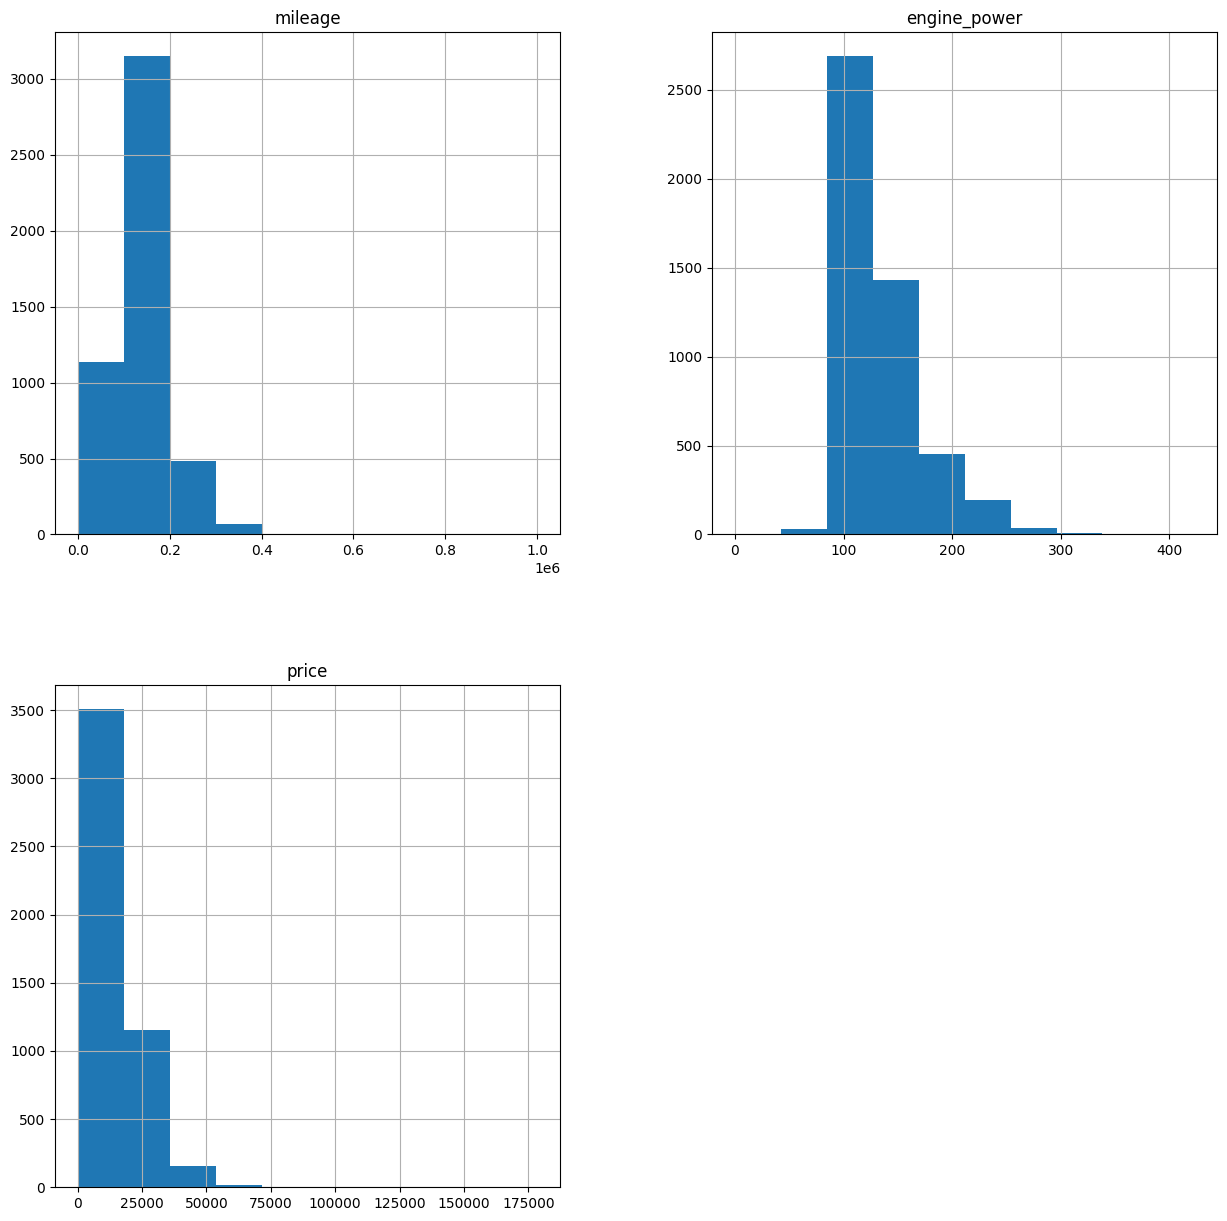

In [83]:
# numerical columns
numerical_variables = df.dtypes[(df.dtypes=="int64")].index.values.tolist()

#plot a histogram of numerical columns
df[numerical_variables].hist(figsize=[15,15])
plt.show()

### 2.4. Histogram of categorical variables

Plot the histogram of the categorical features.

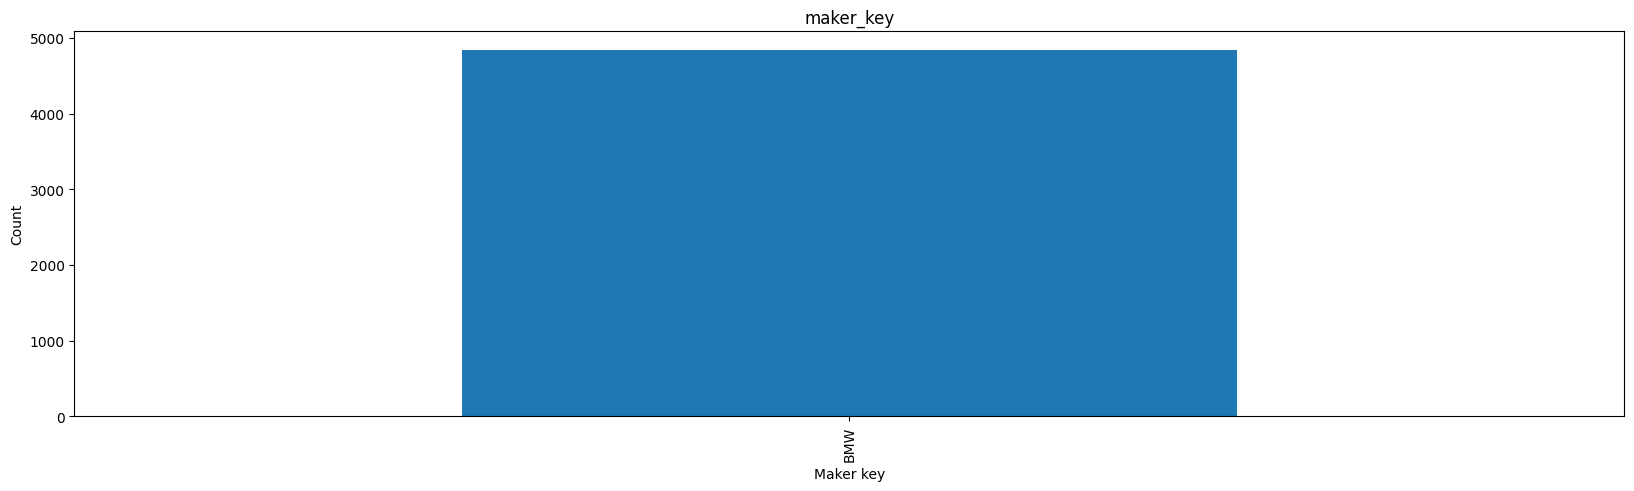

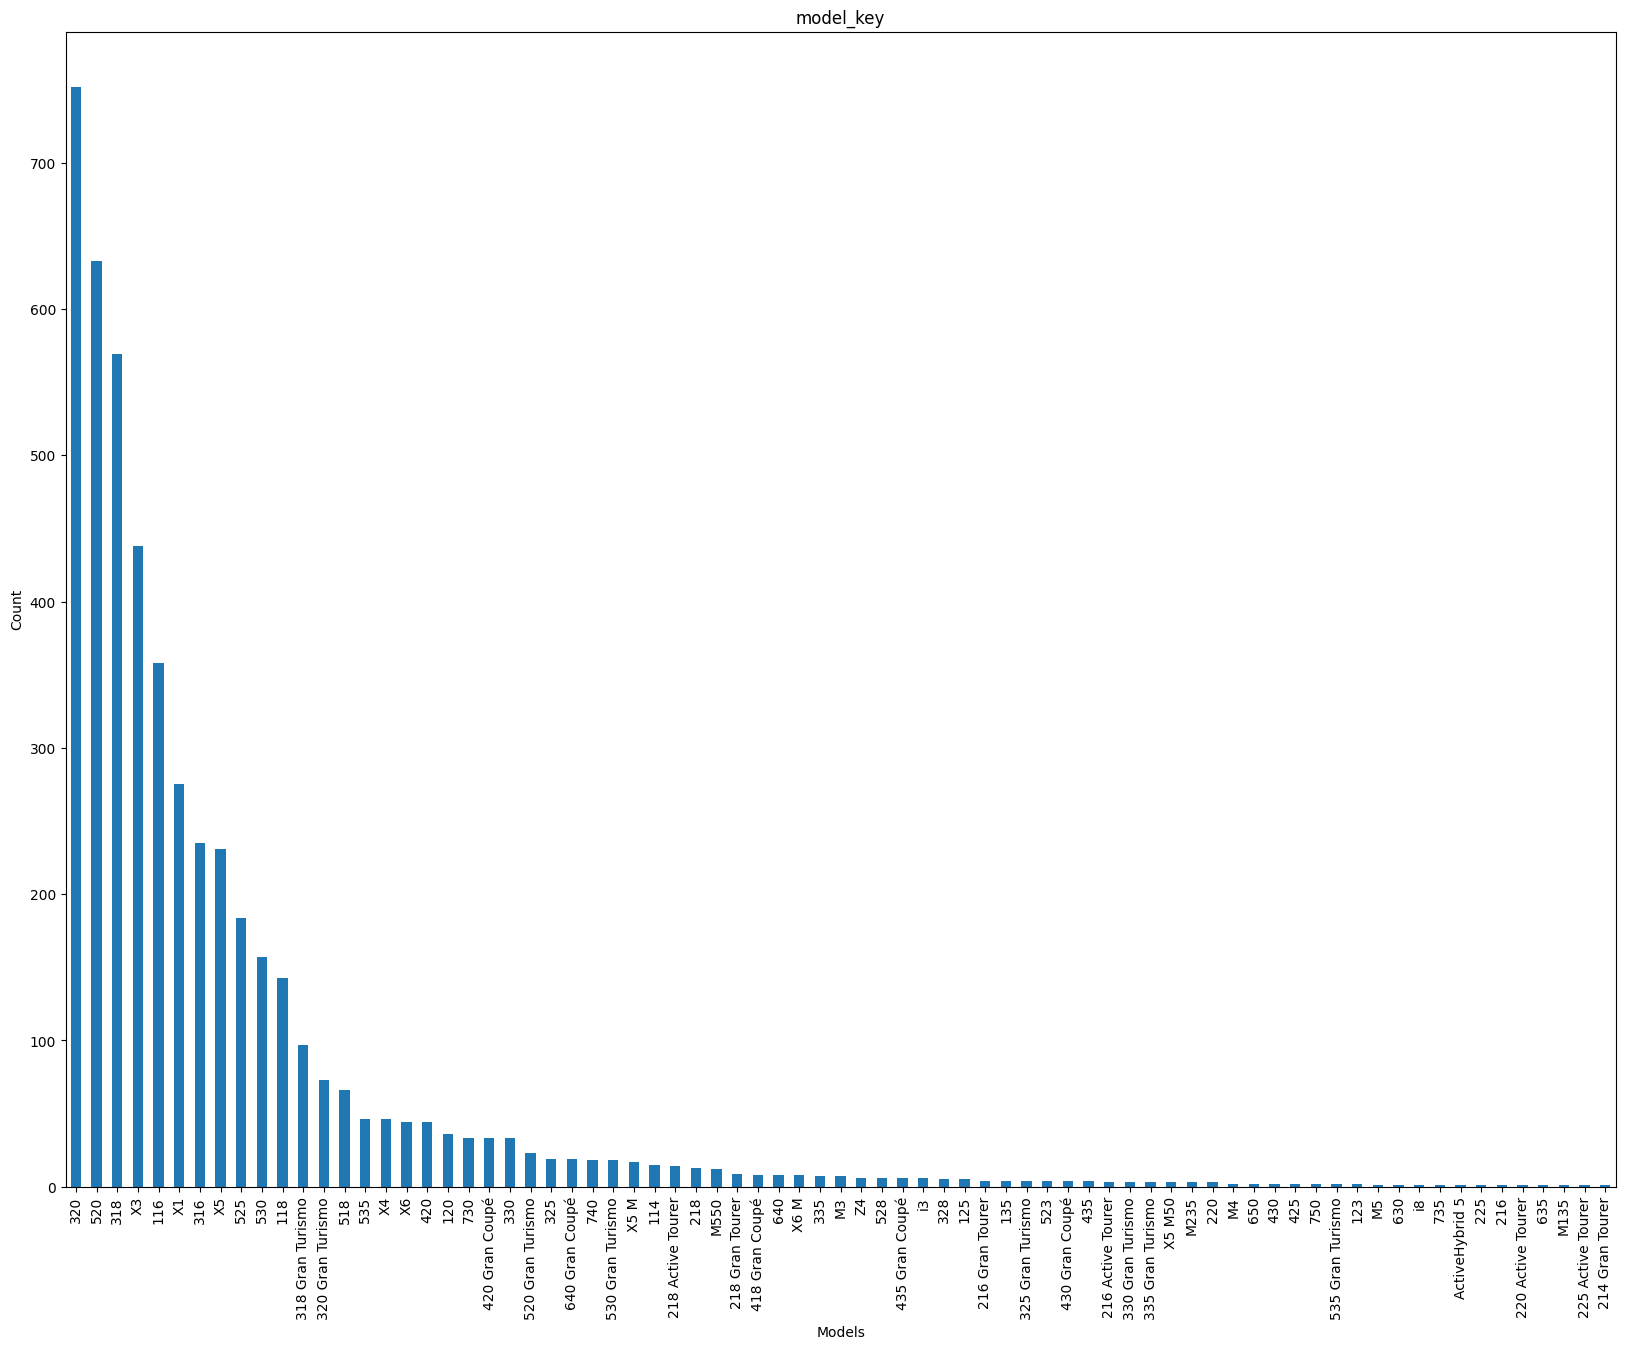

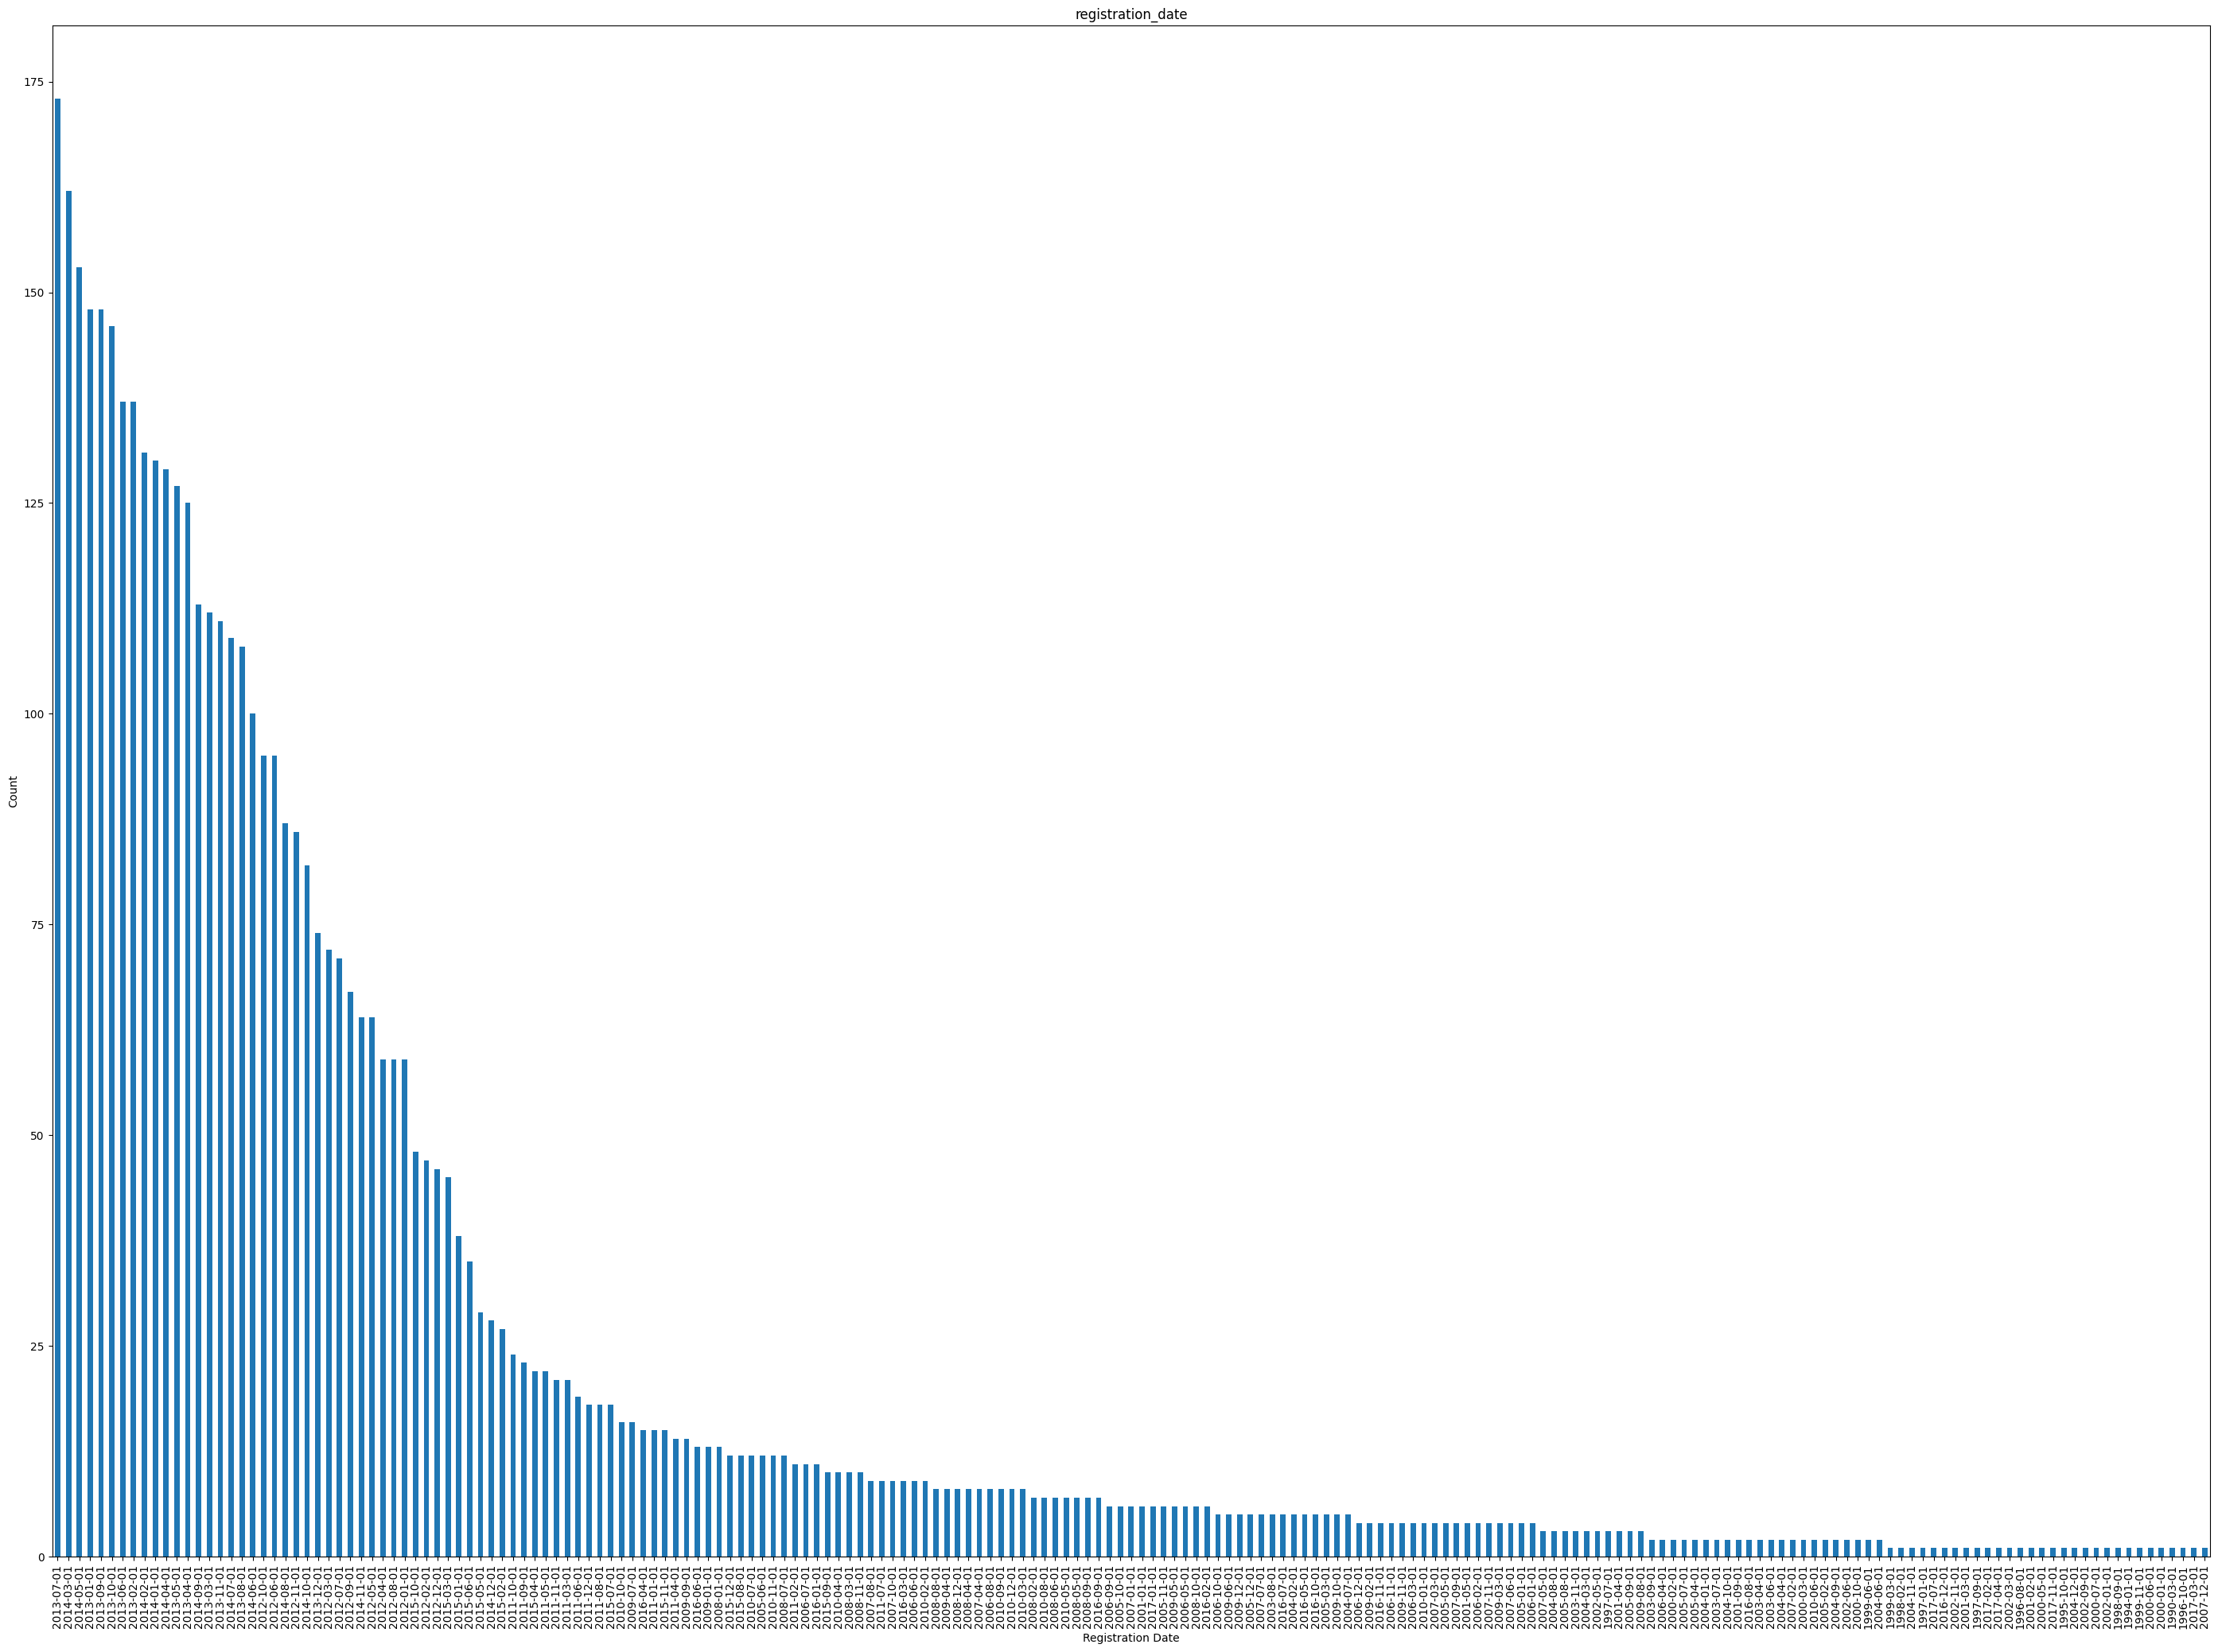

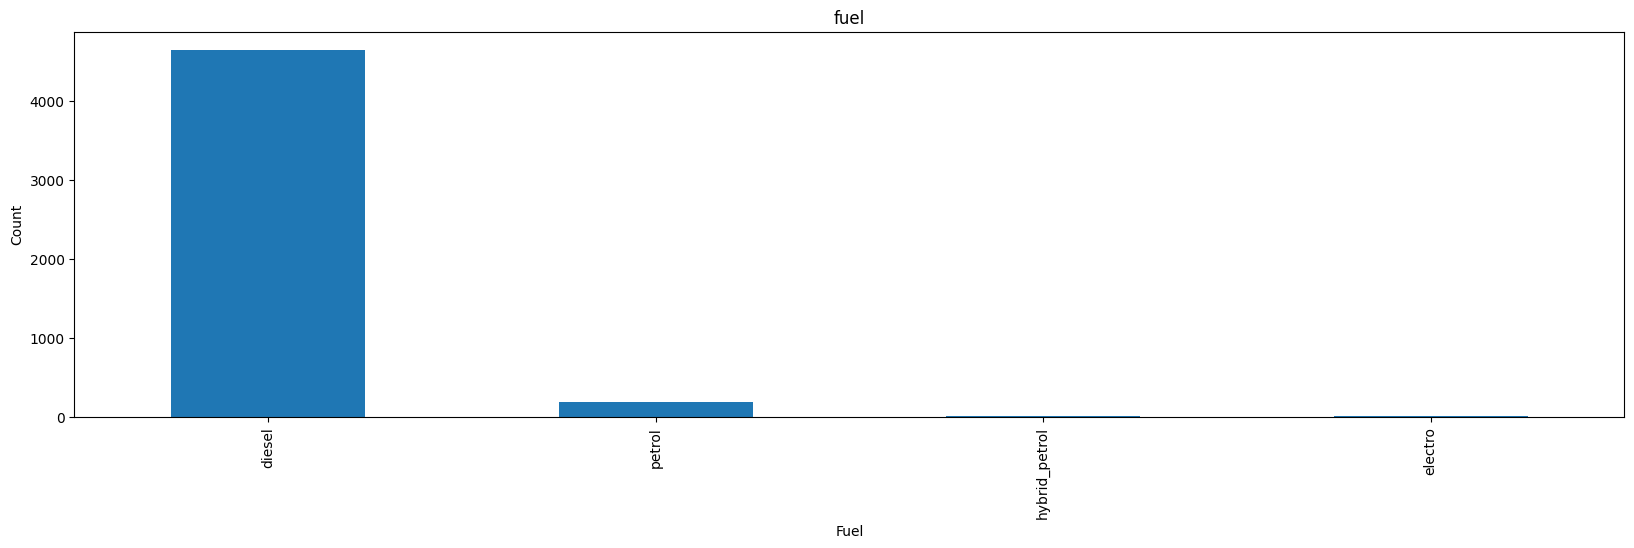

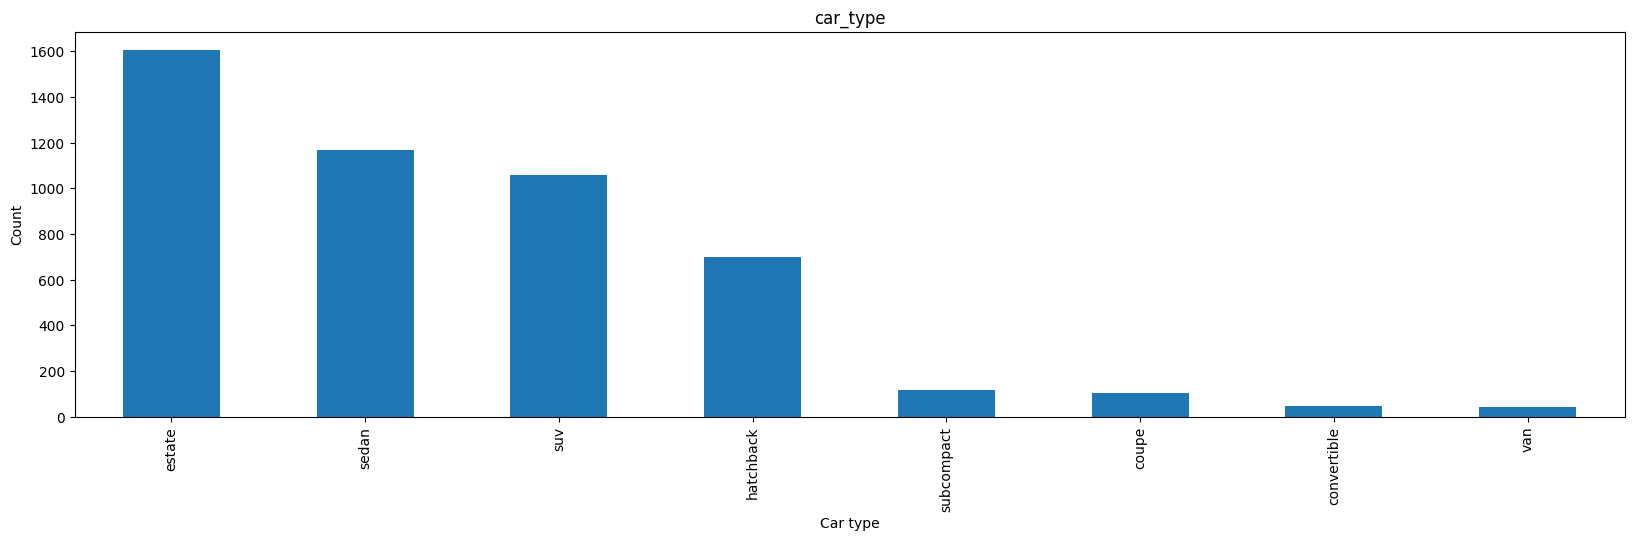

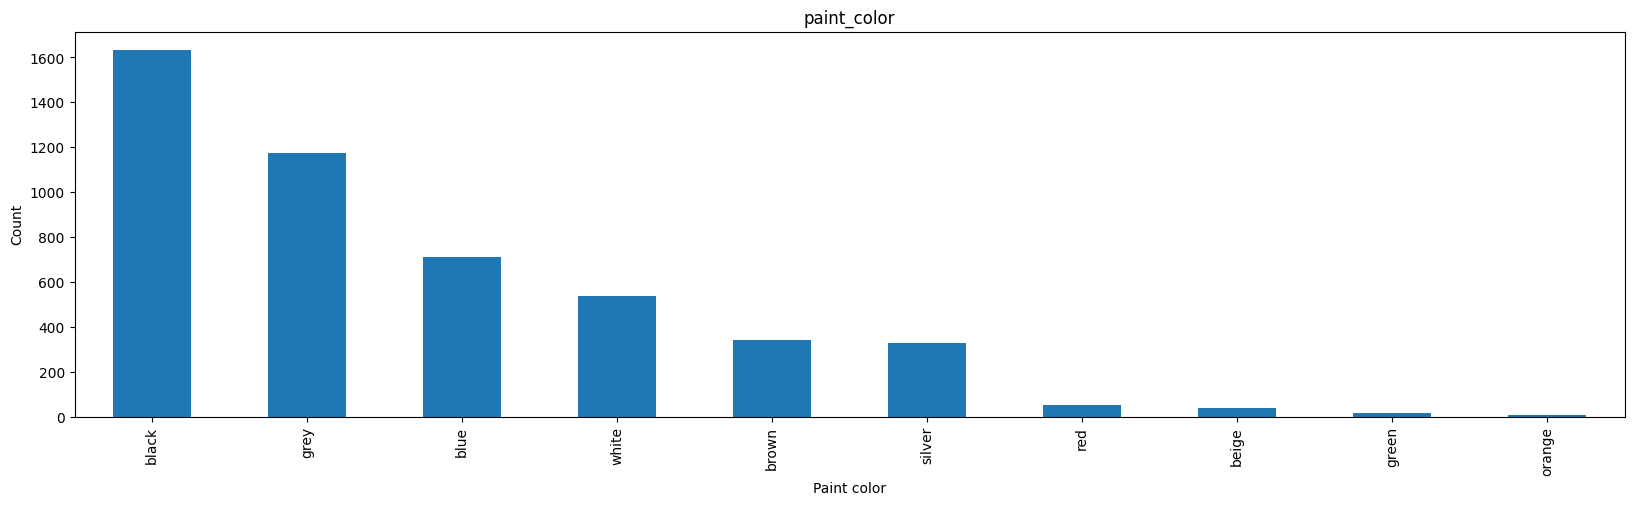

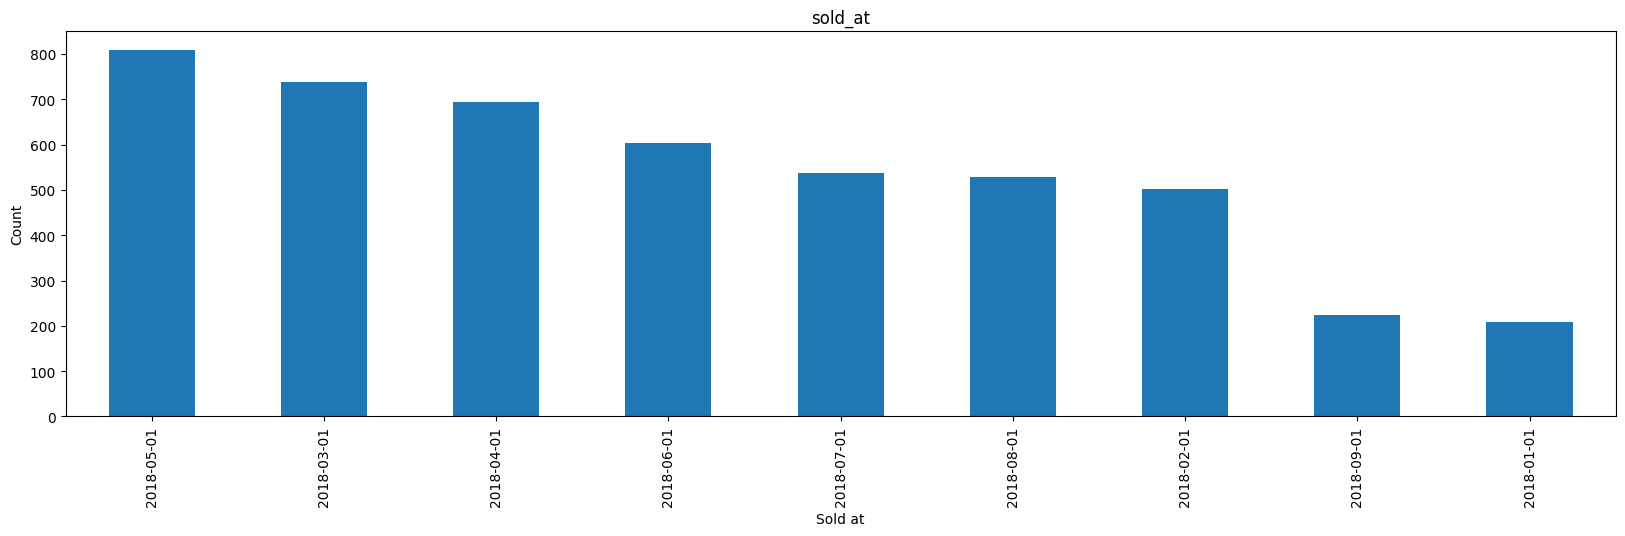

In [84]:
#For design purposes, I decided to do each category alone

#We don't really need the historgram for the maker_key since they're all bmw cars but I still did the histogram. Histogram for maker_key:

#Histogram for car type
fig = plt.figure(figsize=(20,5))
df['maker_key'].value_counts().plot.bar()
plt.xlabel('Maker key')
plt.ylabel('Count')
plt.title('maker_key')
plt.show()

#Histogram for car model
fig = plt.figure(figsize=(20,15))
df['model_key'].value_counts().plot.bar()
plt.xlabel('Models')
plt.ylabel('Count')
plt.title('model_key')
plt.show()

#Histogram for registration date
fig = plt.figure(figsize=(35,25))
df['registration_date'].value_counts().plot.bar()
plt.xlabel('Registration Date')
plt.ylabel('Count')
plt.title('registration_date')
plt.show()

#Histogram for fuel
fig = plt.figure(figsize=(20,5))
df['fuel'].value_counts().plot.bar()
plt.xlabel('Fuel')
plt.ylabel('Count')
plt.title('fuel')
plt.show()

#Histogram for car type
fig = plt.figure(figsize=(20,5))
df['car_type'].value_counts().plot.bar()
plt.xlabel('Car type')
plt.ylabel('Count')
plt.title('car_type')
plt.show()

#Histogram for paint color
fig = plt.figure(figsize=(20,5))
df['paint_color'].value_counts().plot.bar()
plt.xlabel('Paint color')
plt.ylabel('Count')
plt.title('paint_color')
plt.show()

#Histogram for sold_at
fig = plt.figure(figsize=(20,5))
df['sold_at'].value_counts().plot.bar()
plt.xlabel('Sold at')
plt.ylabel('Count')
plt.title('sold_at')
plt.show()

## 3. Data Splitting

Split the dataset into 2 training and test datasets.

In [85]:
X = df.drop('price', axis=1)  # Features
y = df['price']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3874, 17)
(3874,)
(969, 17)
(969,)


## 4. Feature Engineering

### 4.1. Removing non-predictive features

Remove any unnecessary feature.

In [86]:
remove_features = ['maker_key']
df_new = df.drop(remove_features, axis=1)
df_new.head()

,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,118,140411,100,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,2018-01-01
1,M4,13929,317,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2018-02-01
2,320,183297,120,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2018-02-01
3,420,128035,135,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2018-02-01
4,425,97097,160,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,2018-04-01


### 4.2. Creating new features

Creating polynomial features for numerical columns

In [104]:
numerical_columns = df.select_dtypes(include=['int64']).columns

# Adding polynomial features
polynomial_features= PolynomialFeatures(degree=2, include_bias=True)
X_poly = polynomial_features.fit_transform(df[numerical_columns])

### 4.3. Scaling numerical variables

In [105]:
numerical_columns = df_new.select_dtypes(include=['int64']).columns
X_numeric = df_new[numerical_columns]

scaler = StandardScaler()

# Fit and transform the numerical features
X_scaled = scaler.fit_transform(X_numeric)

df_new[numerical_columns] = X_scaled

df_new.head()

,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,118,-0.009168,-0.743491,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,-0.491151,2018-01-01
1,M4,-2.110528,4.822133,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,5.843364,2018-02-01
2,320,0.703337,-0.230530,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,-0.610465,2018-02-01
3,420,-0.214781,0.154190,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,1.005704,2018-02-01
4,425,-0.728782,0.795391,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,1.905986,2018-04-01


### 4.4. Categorical variables encoding

Convert categorical columns into numerical columns using label encoding or one-hot encoding.

In [106]:
le = LabelEncoder()
df_new['model_key'] =le.fit_transform(df_new['model_key'])+1
df_new['fuel'] = le.fit_transform(df_new['fuel'])+1
df_new['car_type'] = le.fit_transform(df_new['car_type'])+1
df_new['paint_color'] = le.fit_transform(df_new['paint_color'])+1
df_new['registration_date'] = le.fit_transform(df_new['registration_date'])+1
df_new['sold_at'] = le.fit_transform(df_new['sold_at'])+1

df_new.head()

,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,3,-0.009168,-0.743491,135,1,2,1,True,True,False,False,True,True,True,False,-0.491151,1
1,62,-2.110528,4.822133,185,4,6,1,True,True,False,False,False,True,True,True,5.843364,2
2,22,0.703337,-0.230530,137,1,10,1,False,False,False,False,True,False,True,False,-0.610465,2
3,32,-0.214781,0.154190,164,1,8,1,True,True,False,False,True,True,True,True,1.005704,2
4,34,-0.728782,0.795391,169,1,9,1,True,True,False,False,False,True,True,True,1.905986,4


### 4.5. Converting boolean columns

In [107]:
for i in range(1,9):
    df_new['feature_'+str(i)]=df_new['feature_'+str(i)]*1
    df_new['feature_'+str(i)]=df_new['feature_'+str(i)].astype(int)

df_new.head()

,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,3,-0.009168,-0.743491,135,1,2,1,1,1,0,0,1,1,1,0,-0.491151,1
1,62,-2.110528,4.822133,185,4,6,1,1,1,0,0,0,1,1,1,5.843364,2
2,22,0.703337,-0.230530,137,1,10,1,0,0,0,0,1,0,1,0,-0.610465,2
3,32,-0.214781,0.154190,164,1,8,1,1,1,0,0,1,1,1,1,1.005704,2
4,34,-0.728782,0.795391,169,1,9,1,1,1,0,0,0,1,1,1,1.905986,4


## 5. Linear Regression

Fit a linear regression model on the training set. Evaluate the model on the testing set. Use the $R^2$ as an evaluation metric.

In [115]:
# Extracting features (X) and target variable (y) from the new df
X = df_new.drop('price', axis=1)
y = df_new['price']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

# Initialize the Linear Regression model
linear_model = LinearRegression()

# Fit
linear_model.fit(X_train, y_train)

# Predict
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

# Evaluating the model
r2 = r2_score(y_test, y_test_pred)

# Print the R^2 score
print('R2 score is {}'.format(r2))

R2 score is 0.7301227682388043


Plot feature importance/weight.

<Axes: title={'center': 'Model Coefficients'}>

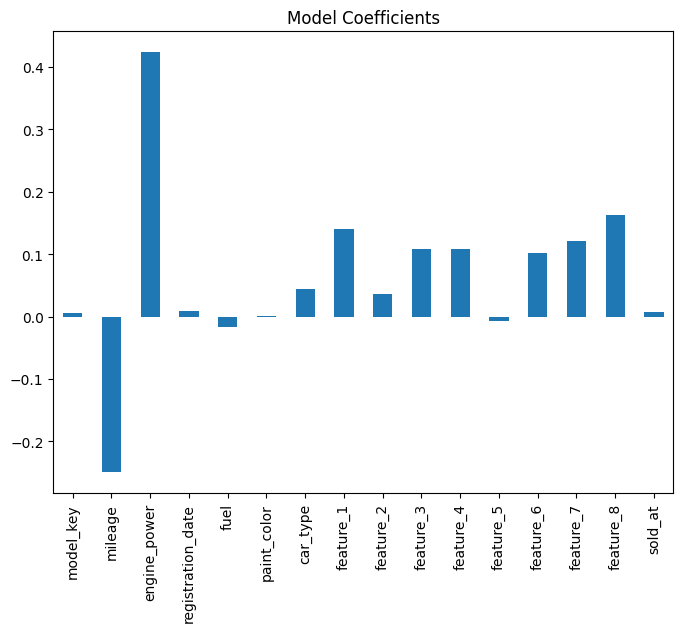

In [118]:
feature_cols = X.columns

coef = pd.Series(linear_model.coef_, feature_cols)

plt.figure(figsize=(8, 6))
coef.plot(kind='bar', title='Model Coefficients')


## 6. Ridge

Fit a ridge regression model on the training set. Use cross-validation in order to tune the regularization parameter of the ridge model. Evaluate the model on the testing set. Use the $R^2$ as an evaluation metric.

In [119]:
model_ridge = Ridge(alpha=0.05)
model_ridge.fit(X_train, y_train)

# predicting over training & testing datasets
y_train_pred = model_ridge.predict(X_train)
y_test_pred = model_ridge.predict(X_test)

# Evaluating the model
rmse = (np.sqrt(mean_squared_error(y_test, y_test_pred)))
r2 = r2_score(y_test, y_test_pred)

# Print the R^2 score
print('R2 score is {}'.format(r2))

R2 score is 0.7301228560486656


Plot feature importance/weight.

<Axes: title={'center': 'Model Coefficients'}>

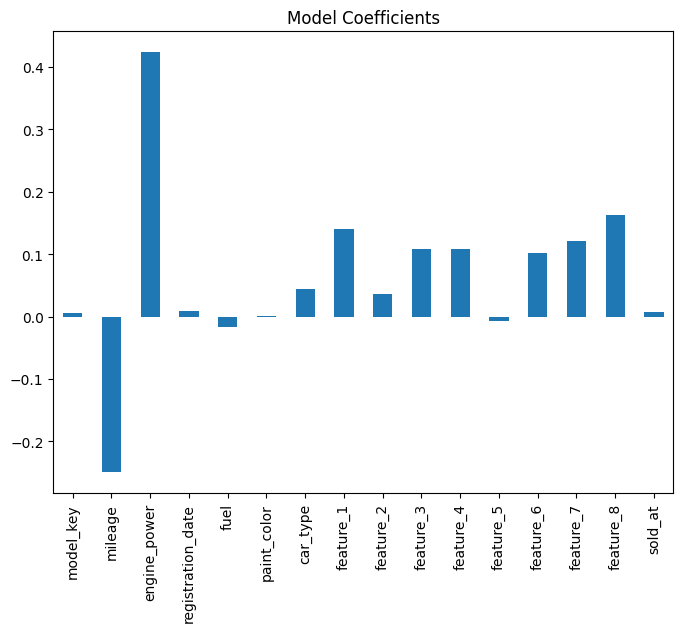

In [120]:
coef = pd.Series(model_ridge.coef_, feature_cols)

plt.figure(figsize=(8, 6))
coef.plot(kind='bar', title='Model Coefficients')

## 7. Lasso

Fit a lasso regression model on the training set. Use cross-validation in order to tune the regularization parameter of the ridge model. Evaluate the model on the testing set. Use the $R^2$ as an evaluation metric.

In [121]:
## training the model
param_grid = {'alpha': [10**(-5), 10**(-4), 10**(-3), 0.005, 0.008, 0.01, 0.05, 0.1, 0.5, 1, 10]}

model_lasso = Lasso()
search = GridSearchCV(model_lasso, param_grid, scoring='r2', cv=5)
search.fit(X_train, y_train)

# predicting over training & testing datasets
y_train_pred = search.predict(X_train)
y_test_pred = search.predict(X_test)

# Evaluating the model
rmse = (np.sqrt(mean_squared_error(y_test, y_test_pred)))
r2 = r2_score(y_test, y_test_pred)

# Print the R^2 score
print('R2 score is {}'.format(r2))

R2 score is 0.7301202377065086


Plot feature importance/weight.

<Axes: title={'center': 'Model Coefficients'}>

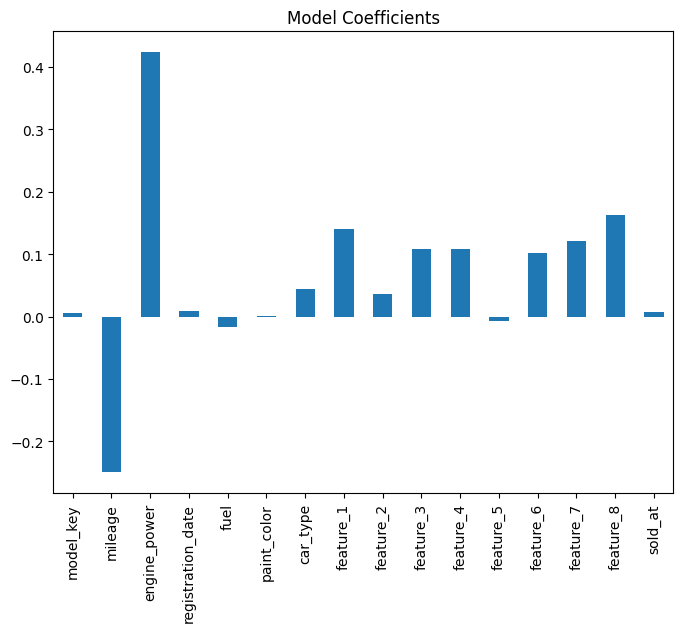

In [122]:
coef = pd.Series(search.best_estimator_.coef_,feature_cols)
plt.figure(figsize=(8, 6))
coef.plot(kind='bar', title='Model Coefficients')